# Regresssion with outliers

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from plugins import plot_training_data
from plugins import plot_sampled_trace
from plugins import plot_parameter_dist

In [2]:
%%capture
%load_ext jupyter_probcomp.magics
%matplotlib inline

Load the read infer predict layer (ripl) and set venture's random seed to 1 to
ensure reproducibility.

In [3]:
%ripl --seed 1 --plugins plugins.py

Set seed of a new VentureScript RIPL to 1.00.
Loading plugin: plugins.py


## 1. Venture model component

In [4]:
%%venturescript
// MODEL

assume slope       = normal(0, 1) #continuous:0;
assume intercept   = normal(0, 1) #continuous:1;
assume inlier_noise =  -log_logistic(log_odds_uniform() #continuous:2) * 2;
//assume outlier_noise =   -log_logistic(log_odds_uniform() #continuous:3) * 100;
assume outlier_noise = 25;
                                    
assume outlier_probability = 0.1;
                                    
assume is_outlier = mem((x) -> {
    flip(outlier_probability) #discrete:x
});
                                    
assume model = (x) -> { 
    if (is_outlier(x)) {
        normal(slope * x + intercept, outlier_noise)
    } else {
        normal(slope * x + intercept, inlier_noise)
    }
    
};
// Load data                  
define data_xs = load_csv(str_concat(get_path(), "/training_xs.csv"));
define data_ys = load_csv(str_concat(get_path(), "/training_ys.csv")); 
// Helper function:
define get_outlier_assignments = () -> {
  mapv(
      (x) -> run({sample(is_outlier($x))}),
      data_xs
  )  
};

##  Priors

In [5]:
prior = []
for _ in range(100):
    %venturescript reset_to_prior;
    slope         = %venturescript sample slope
    intercept     = %venturescript sample intercept
    inlier_noise  = %venturescript sample inlier_noise
    outlier_noise = %venturescript sample outlier_noise
    prior.append([slope, intercept, inlier_noise, outlier_noise])
prior = np.asarray(prior)

##### Keeping outlier noise fixed for now.

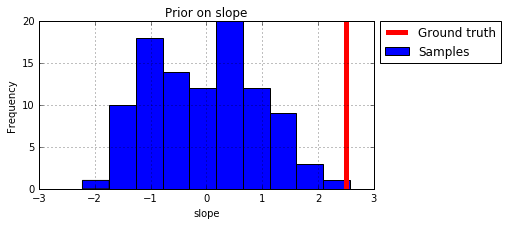

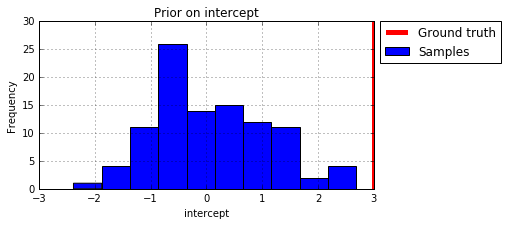

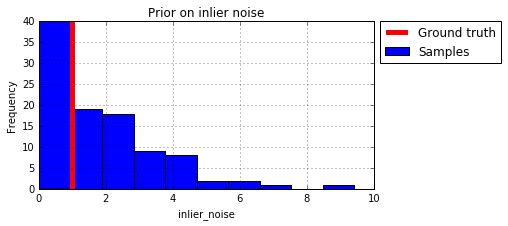

In [6]:
fig, ax = plot_parameter_dist(
    prior[:,0], 'Prior on slope', 'slope'
)
fig, ax = plot_parameter_dist(
    prior[:,1], 'Prior on intercept', 'intercept'
)
fig, ax = plot_parameter_dist(
    prior[:,2], 'Prior on inlier noise', 'inlier_noise'
)

### Plot training data

In [7]:
data_xs = %venturescript data_xs
data_ys = %venturescript data_ys

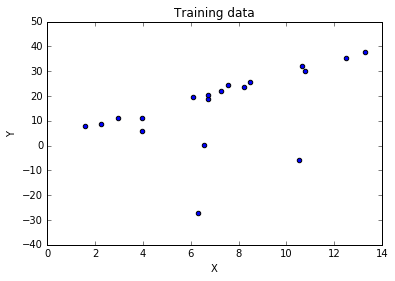

In [8]:
fig, ax = plt.subplots()
ax.scatter(data_xs, data_ys)
ax.set_title('Training data')
ax.set_xlabel('X')
ax.set_ylabel('Y')

## 3. Venture observation component

In [9]:
%%venturescript
// OBSERVATIONS
for_each(arange(size(data_xs)),
    (i) -> {
    observe model(${data_xs[i]}) = data_ys[i]
});

## 4. Venture infererence components

In [10]:
%%venturescript
// INFERENCE
define single_site_mh  = () -> {
    mh(default, one, 1)
};

define resimulation_mh  = () -> {
    mh(default, all, 1)
};

define lbfgs_with_gibbs = () -> {
    lbfgs_optimize(quote(continuous), all);
    gibbs_pass()
};
define gibbs_pass = () -> {
    for_each(data_xs,
        (x) -> {
            gibbs(quote(discrete), x, 1)
        }
    )
};
define sequential_monte_carlo_lbfgs_gibbs = () -> {
    observe model(${data_xs[0]}) = data_ys[0];
    observe model(${data_xs[1]}) = data_ys[1];
    lbfgs_optimize(quote(continuous), all);
    for_each(arange(2, size(data_xs)),
        (i) -> {
        observe model(${data_xs[i]}) = data_ys[i]
    });
    gibbs_pass();
    
};

## 5. Samples from the prior

In [11]:
def plot_trace(title):
    outliers = %venturescript get_outlier_assignments()
    slope      = %venturescript sample slope
    intercept  = %venturescript sample intercept
    std = %venturescript sample inlier_noise
    outlier_std = %venturescript sample outlier_noise
    fig, ax = plot_sampled_trace(data_xs, data_ys, outliers, slope, intercept, std, outlier_std)
    ax.set_title('Sampled trace -- %s' % title)

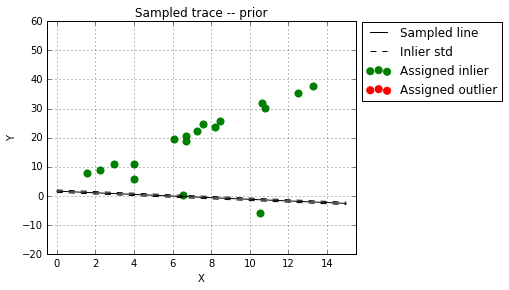

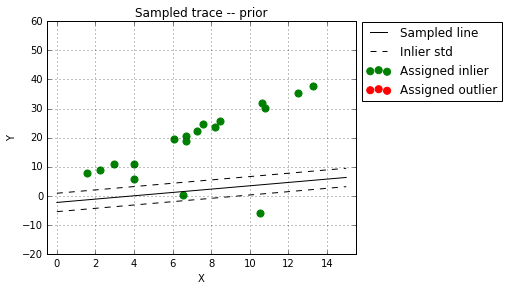

In [12]:
plot_trace('prior')
%venturescript reset_to_prior;
plot_trace('prior')

## Run inference

### SMC -- LBFGS &  Gibbs

In [13]:
%%venturescript
sequential_monte_carlo_lbfgs_gibbs();

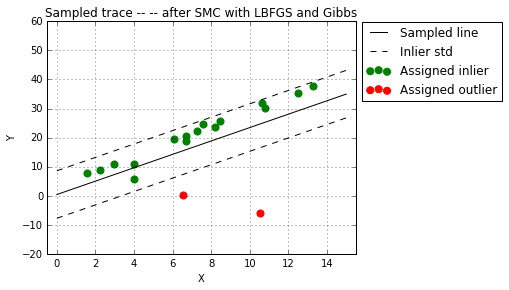

In [14]:
plot_trace('-- after SMC with LBFGS and Gibbs')

### Single-variable MH

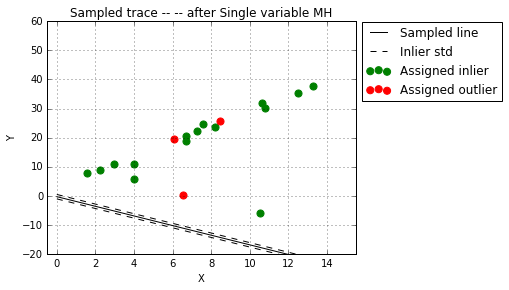

In [15]:
%venturescript reset_to_prior;
%venturescript single_site_mh();
plot_trace('-- after Single variable MH')

### Global MH

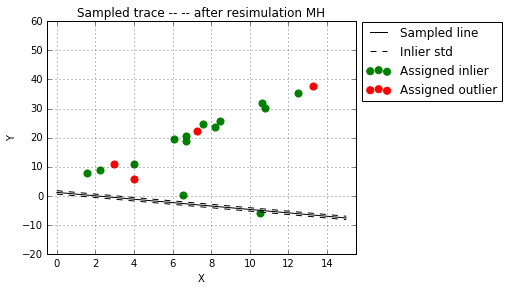

In [16]:
%venturescript reset_to_prior;
%venturescript resimulation_mh();
plot_trace('-- after resimulation MH')